# **PROYECTO DE GRADO - MAESTRIA EN CIENCIA DE DATOS**
## Segmentación de profesionales de la salud del sector farmacéutico
### Santiago Reyes Zabaleta


## Entregable Final a Sanofi
-------------------------------------------------------------------------------------

Precisión del modelo: 0.99

Reporte de clasificación:
              precision    recall  f1-score   support

   Cluster A       0.97      0.97      0.97        36
   Cluster B       0.99      0.99      0.99        97
   Cluster C       1.00      1.00      1.00        31

    accuracy                           0.99       164
   macro avg       0.99      0.99      0.99       164
weighted avg       0.99      0.99      0.99       164



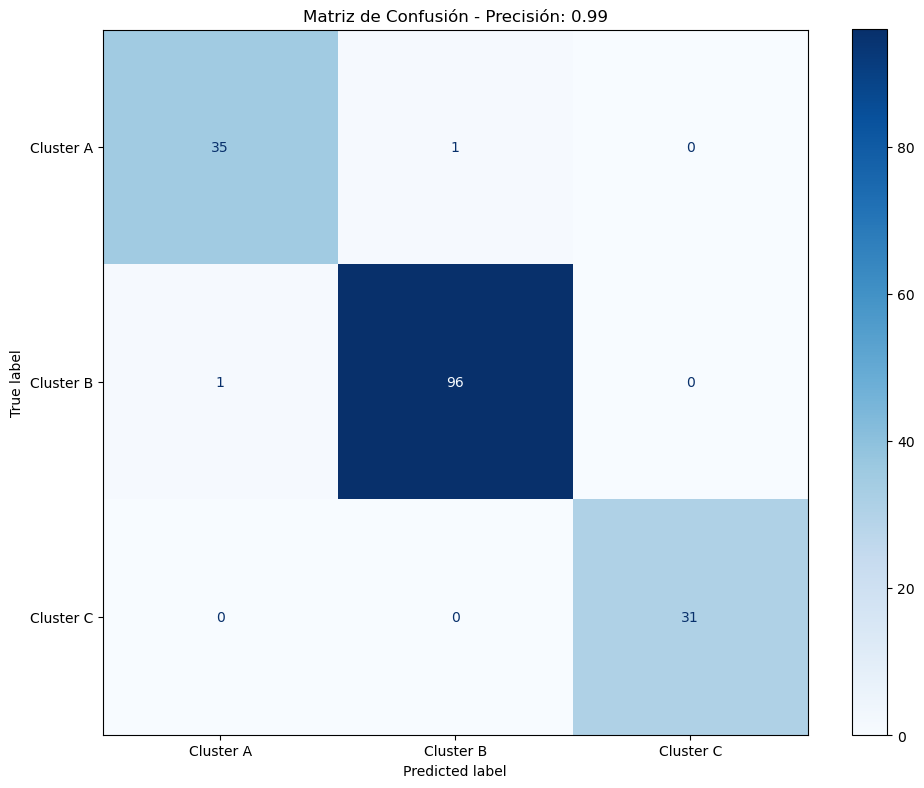

Modelo guardado en: random_forest_model.pkl
Archivo con las predicciones guardado en: predicciones_resultado.csv

Tabla de conteo por clúster (ordenada de mayor a menor):
cluster_label
Cluster B    321
Cluster A    121
Cluster C    104
Name: count, dtype: int64


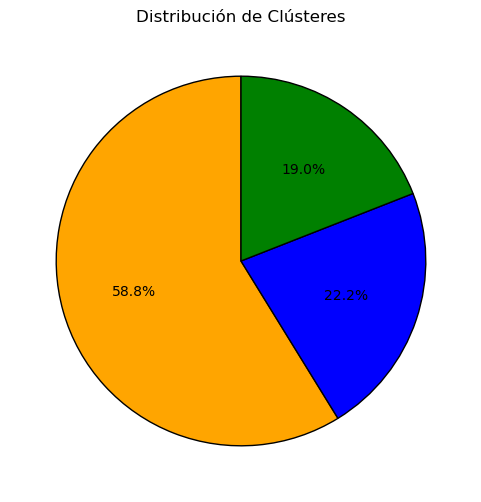


Análisis cruzado por especialidad y clúster (ordenado de mayor a menor):


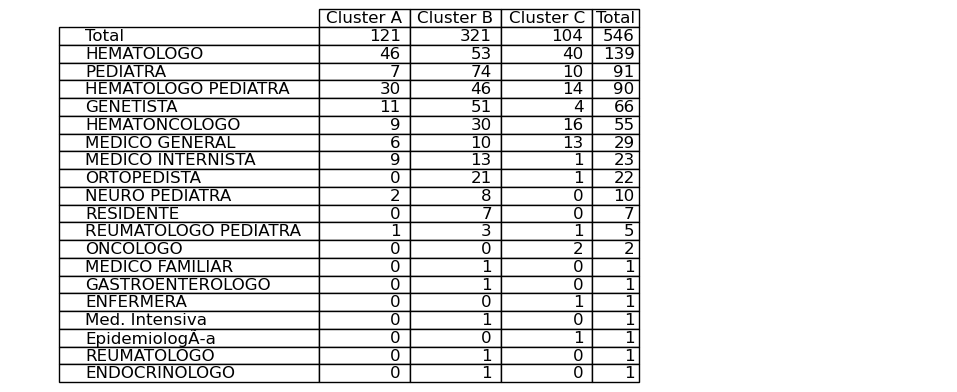

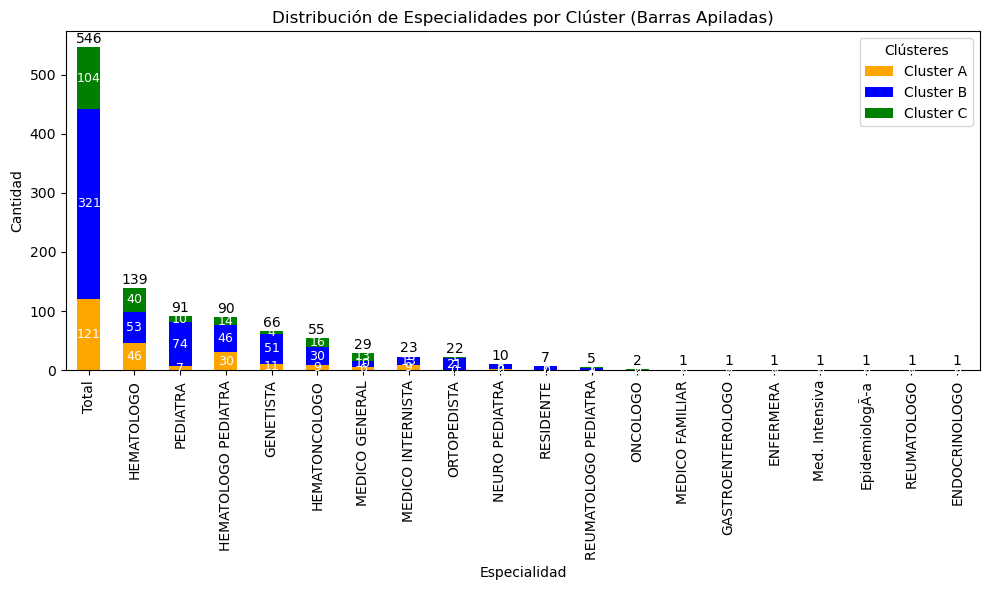

In [20]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from pandas.plotting import table
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

def mostrar_tabla_en_jupyter(df):
    """
    Muestra un DataFrame como una tabla dentro del cuaderno Jupyter.
    
    Args:
        df (DataFrame): El DataFrame que se desea visualizar.
    """
    fig, ax = plt.subplots(figsize=(10, 4))  # Ajusta el tamaño de la figura
    ax.axis('off')  # Oculta los ejes
    tabla = table(ax, df, loc='center', colWidths=[0.2]*len(df.columns))  # Crea la tabla en el centro
    tabla.auto_set_font_size(False)  # Desactiva el ajuste automático de tamaño de fuente
    tabla.set_fontsize(12)  # Ajusta el tamaño de la fuente
    tabla.auto_set_column_width(col=list(range(len(df.columns))))  # Ajusta el ancho de las columnas
    plt.tight_layout()
    plt.show()  # Muestra la tabla en el cuaderno

def entrenar_y_procesar(input_train_path, model_path='random_forest_model.pkl'):
    """
    Carga los datos, entrena un modelo Random Forest, realiza predicciones y genera gráficos de evaluación.
    
    Args:
        input_train_path (str): Ruta del archivo CSV con los datos para entrenamiento y predicción.
        model_path (str): Ruta para guardar el modelo entrenado.
    """
    # Cargar datos
    df_combinado = pd.read_csv(input_train_path)

    # Preparar los datos
    label_encoder = LabelEncoder()
    df_combinado['tipo_consulta_encoded'] = label_encoder.fit_transform(df_combinado['tipo_consulta'])

    # Variables de entrada (X) y salida (y)
    X = df_combinado[['Cantidad_pacientes', 'tipo_consulta_encoded', 'porcentaje_consulta']]
    y = df_combinado['cluster_label']  # Variable de salida 'cluster_label'

    # Escalar las características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

    # Entrenar el modelo
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo: {accuracy:.2f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

    # Mostrar la matriz de confusión
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title(f"Matriz de Confusión - Precisión: {accuracy:.2f}")
    plt.tight_layout()
    plt.show()

    # Guardar el modelo entrenado
    joblib.dump((rf_model, scaler, label_encoder), model_path)
    print(f"Modelo guardado en: {model_path}")

def predecir_y_guardar(input_pred_path, model_path='random_forest_model.pkl', output_pred_path='predicciones.csv'):
    """
    Usa el modelo entrenado para predecir 'cluster' y 'cluster_label' y genera un archivo de salida con las predicciones.
    
    Args:
        input_pred_path (str): Ruta del archivo CSV con los datos para predicción.
        model_path (str): Ruta del modelo guardado.
        output_pred_path (str): Ruta del archivo CSV para guardar las predicciones.
    """
    # Cargar el modelo previamente guardado
    rf_model, scaler, label_encoder = joblib.load(model_path)

    # Cargar datos para predicciones
    new_data = pd.read_csv(input_pred_path)

    # Verificar que las columnas requeridas estén presentes
    required_columns = ['ONE KEY', 'Cantidad_pacientes', 'tipo_consulta', 'porcentaje_consulta', 'especialidad']
    if not all(col in new_data.columns for col in required_columns):
        raise ValueError(f"El archivo debe contener las columnas: {required_columns}")

    # Preprocesar los datos
    new_data['tipo_consulta_encoded'] = label_encoder.transform(new_data['tipo_consulta'])
    new_data_scaled = scaler.transform(new_data[['Cantidad_pacientes', 'tipo_consulta_encoded', 'porcentaje_consulta']])

    # Realizar predicciones
    cluster_predictions = rf_model.predict(new_data_scaled)

    # Verificar si las predicciones ya son etiquetas de clúster y asignarlas
    if isinstance(cluster_predictions[0], str):
        # Si las predicciones ya son etiquetas como 'Cluster A', 'Cluster B', etc.
        new_data['cluster_label'] = cluster_predictions
    else:
        # Si son valores numéricos, mapeamos a las etiquetas de los clústeres
        cluster_mapping = {0: 'Cluster B', 1: 'Cluster C', 2: 'Cluster A'}
        new_data['cluster'] = cluster_predictions
        new_data['cluster_label'] = [cluster_mapping[pred] for pred in cluster_predictions]

    # Guardar las predicciones en un archivo CSV
    new_data.to_csv(output_pred_path, index=False)
    print(f"Archivo con las predicciones guardado en: {output_pred_path}")

    # **Análisis estadístico de las predicciones**
    
    # 1. Tabla por clúster (ordenada de mayor a menor)
    cluster_counts = new_data['cluster_label'].value_counts().sort_values(ascending=False)
    print("\nTabla de conteo por clúster (ordenada de mayor a menor):")
    print(cluster_counts)

    # 2. Diagrama circular con porcentajes (sin etiquetas numéricas)
    plt.figure(figsize=(6, 6))
    wedges, texts, autotexts = plt.pie(cluster_counts, autopct='%1.1f%%', colors=['orange', 'blue', 'green'], startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title("Distribución de Clústeres")
    plt.show()

    # 3. Análisis cruzado por especialidad y clúster (con totales de fila y columna)
    cross_tab = pd.crosstab(new_data['especialidad'], new_data['cluster_label'])
    
    # Añadir la fila de totales
    cross_tab['Total'] = cross_tab.sum(axis=1)
    
    # Añadir la columna de totales
    cross_tab.loc['Total'] = cross_tab.sum(axis=0)

    # Ordenar por la columna de totales
    cross_tab = cross_tab.sort_values(by='Total', ascending=False)

    print("\nAnálisis cruzado por especialidad y clúster (ordenado de mayor a menor):")
    mostrar_tabla_en_jupyter(cross_tab)

    # 4. Diagrama de barras apiladas (especialidades como etiquetas, clústeres apilados)
    cross_tab.drop('Total', axis=1, inplace=True)  # Eliminamos la columna de totales para la visualización
    ax = cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['orange', 'blue', 'green'])

    # Agregar etiquetas de datos (numeros) a las barras apiladas
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x = p.get_x()
        y = p.get_y()

        # Etiqueta de los valores numéricos
        ax.text(x + width / 2, y + height / 2, f'{int(height)}', ha='center', va='center', fontsize=9, color='white')

    # Agregar los totales encima de cada barra
    for i in range(len(cross_tab)):
        total = sum(cross_tab.iloc[i])
        ax.text(i, total + 2, f'{total}', ha='center', va='bottom', fontsize=10, color='black')

    plt.title("Distribución de Especialidades por Clúster (Barras Apiladas)")
    plt.xlabel("Especialidad")
    plt.ylabel("Cantidad")
    plt.legend(title="Clústeres", loc='upper right')
    plt.tight_layout()
    plt.show()

# Entrenar el modelo y guardarlo
input_train_path = 'output_Combinado_Kmeans.csv'  # Ruta del archivo de entrenamiento
model_path = 'random_forest_model.pkl'  # Ruta para guardar el modelo entrenado
entrenar_y_procesar(input_train_path, model_path)

# Predecir y guardar el archivo de salida con las predicciones
input_pred_path = 'archivo_entrada.csv'  # Archivo de entrada para predicciones
output_pred_path = 'predicciones_resultado.csv'  # Archivo de salida con las predicciones
predecir_y_guardar(input_pred_path, model_path, output_pred_path)
